In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

In [38]:
train_df = pd.read_csv('../input/train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('../input/test.csv', parse_dates=['timestamp'])
id_test = test_df.id

In [39]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
hospital_beds_raion,14441,0.473926
build_year,13605,0.446490
state,13559,0.444980
cafe_avg_price_500,13281,0.435857
cafe_sum_500_max_price_avg,13281,0.435857
cafe_sum_500_min_price_avg,13281,0.435857
max_floor,9572,0.314135
material,9572,0.314135
num_room,9572,0.314135
kitch_sq,9572,0.314135


In [23]:
print('Feature Engineering...')
# Add month-year
month_year = (train_df.timestamp.dt.month*30 + train_df.timestamp.dt.year * 365)
month_year_cnt_map = month_year.value_counts().to_dict()
train_df['month_year_cnt'] = month_year.map(month_year_cnt_map)

Feature Engineering...


In [24]:
month_year = (test_df.timestamp.dt.month*30 + test_df.timestamp.dt.year * 365)
month_year_cnt_map = month_year.value_counts().to_dict()
test_df['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [40]:
train_df = train_df.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,319,108,17,135,236,2,91,195,14,16331452


In [26]:
train_df.shape

(30471, 293)

In [27]:
train_df.isnull().sum().max()

0

In [28]:
train_df['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [41]:
X_train = train_df[train_df.columns[:-1]]
y_train = train_df['price_doc']
X_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,1,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,40,9,4,0,13,22,1,0,52,4
1,2,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,...,36,15,3,0,15,29,1,10,66,14
2,3,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,...,25,10,3,0,11,27,0,4,67,10
3,4,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,...,15,11,2,1,4,4,0,0,26,3
4,5,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,552,319,108,17,135,236,2,91,195,14


In [42]:
X_train = X_train.drop(['timestamp','id'],axis =1)


In [43]:
X_train = pd.get_dummies(X_train)

In [44]:
X_train.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,6.407578e+06,...,0,1,0,1,0,0,1,0,0,0
1,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,9.589337e+06,...,0,1,0,1,0,1,0,0,0,0
2,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,4.808270e+06,...,0,1,0,1,0,0,0,0,1,0
3,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,1.258354e+07,...,0,1,0,1,0,0,1,0,0,0
4,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,8.398461e+06,...,0,1,0,0,1,1,0,0,0,0


In [45]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [49]:
important_columns = pd.DataFrame([X_train.columns,regr.feature_importances_]).T.sort_values(1,ascending = False).head(70)
important_columns[0]

0                                   full_sq
1                                   life_sq
2                                     floor
3                                 max_floor
4                                  material
5                                build_year
6                                  num_room
7                                  kitch_sq
8                                     state
9                                    area_m
10                              raion_popul
11                          green_zone_part
13                       children_preschool
12                              indust_part
14                          preschool_quota
15        preschool_education_centers_raion
16                          children_school
66                  build_count_before_1920
21                 healthcare_centers_raion
18           school_education_centers_raion
19    school_education_centers_top_20_raion
20                      hospital_beds_raion
24               additional_educ

In [47]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train[important_columns[0]], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

# Prepare test data

In [29]:
test_total = test_df.isnull().sum().sort_values(ascending=False)
test_percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
test_missing_data = pd.concat([test_total, test_percent], axis=1, keys=['Total', 'Percent'])
test_missing_data.head(20)

,Total,Percent
hospital_beds_raion,3418,0.446098
cafe_sum_500_min_price_avg,3159,0.412294
cafe_avg_price_500,3159,0.412294
cafe_sum_500_max_price_avg,3159,0.412294
preschool_quota,1596,0.208301
school_quota,1595,0.208170
cafe_sum_1000_min_price_avg,1222,0.159488
cafe_sum_1000_max_price_avg,1222,0.159488
cafe_avg_price_1000,1222,0.159488
build_count_1946-1970,1218,0.158966


In [30]:
test_df = test_df.apply(lambda x:x.fillna(x.value_counts().index[0]))

#df.apply(lambda x: x.fillna(x.mean()),axis=0)
test_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,1.0,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [31]:
test_df.isnull().sum().max()

0

In [32]:
X_test = test_df.drop(['timestamp','id'],axis =1)

In [33]:
X_test.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,Investment,...,8,0,0,0,1,10,1,0,14,1
1,79.2,1.0,8,17,1,0.0,3,1.0,1.0,OwnerOccupier,...,4,1,1,0,2,11,0,1,12,1
2,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,Investment,...,42,11,4,0,10,21,0,10,71,11
3,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,OwnerOccupier,...,1,1,2,0,0,10,0,0,2,0
4,40.0,40.0,17,17,1,0.0,1,1.0,1.0,OwnerOccupier,...,5,1,1,0,2,12,0,1,11,1


In [34]:
X_test = pd.get_dummies(X_test)
X_test.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,2.615514e+07,...,0,1,0,1,0,0,0,0,0,1
1,79.2,1.0,8,17,1,0.0,3,1.0,1.0,2.553630e+07,...,0,1,0,1,0,0,0,1,0,0
2,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,9.946335e+06,...,0,1,0,1,0,0,0,0,1,0
3,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,2.149409e+07,...,0,1,0,1,0,0,0,1,0,0
4,40.0,40.0,17,17,1,0.0,1,1.0,1.0,2.553630e+07,...,0,1,0,1,0,0,0,1,0,0


In [59]:
y_tag = regr.predict(X_test[important_columns[0]])

In [60]:
y_tag.shape

(7662L,)

In [61]:
df_sub= pd.DataFrame(columns = ['id','price_doc'])
df_sub ['id'] = test_df['id']
df_sub['price_doc'] = y_tag

In [38]:
df_sub.to_csv('submission_data1.csv',index = False)

In [40]:
X_train.shape

(30471, 451)

# XGB


In [73]:
dtrain = xgb.DMatrix(X_train[important_columns[0]], y_train, feature_names=important_columns[0])

In [74]:
dtest = xgb.DMatrix(X_test[important_columns[0]], feature_names=important_columns[0])

In [75]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}


[0]	train-rmse:8.2053e+06	test-rmse:8.21056e+06
[50]	train-rmse:2.53347e+06	test-rmse:2.89799e+06
[100]	train-rmse:2.20508e+06	test-rmse:2.71038e+06
[150]	train-rmse:2.08644e+06	test-rmse:2.67419e+06
[200]	train-rmse:2.00243e+06	test-rmse:2.65745e+06
[250]	train-rmse:1.93418e+06	test-rmse:2.64633e+06
[300]	train-rmse:1.87577e+06	test-rmse:2.64108e+06
[350]	train-rmse:1.82297e+06	test-rmse:2.63575e+06
[400]	train-rmse:1.77493e+06	test-rmse:2.63155e+06


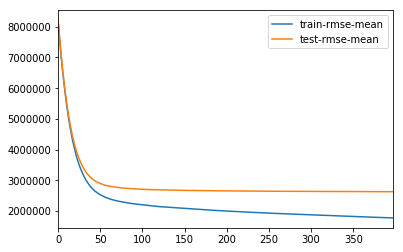

In [45]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [50]:
cv_output.tail(10)

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
388,2.632329e+06,121030.099392,1.785806e+06,22040.292692
389,2.632378e+06,120987.946059,1.785237e+06,21920.609363
390,2.632139e+06,120985.272392,1.784150e+06,21612.456269
391,2.632259e+06,120819.226276,1.783234e+06,21734.423651
392,2.632304e+06,120863.956044,1.782407e+06,21845.514930
393,2.632281e+06,120855.757835,1.781552e+06,21841.195782
394,2.632089e+06,120927.772133,1.780638e+06,21828.390420
395,2.631908e+06,120997.229590,1.779521e+06,21400.437760
396,2.631555e+06,120985.995859,1.778767e+06,21093.006788
397,2.631348e+06,121181.879985,1.777964e+06,21031.174182


In [76]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

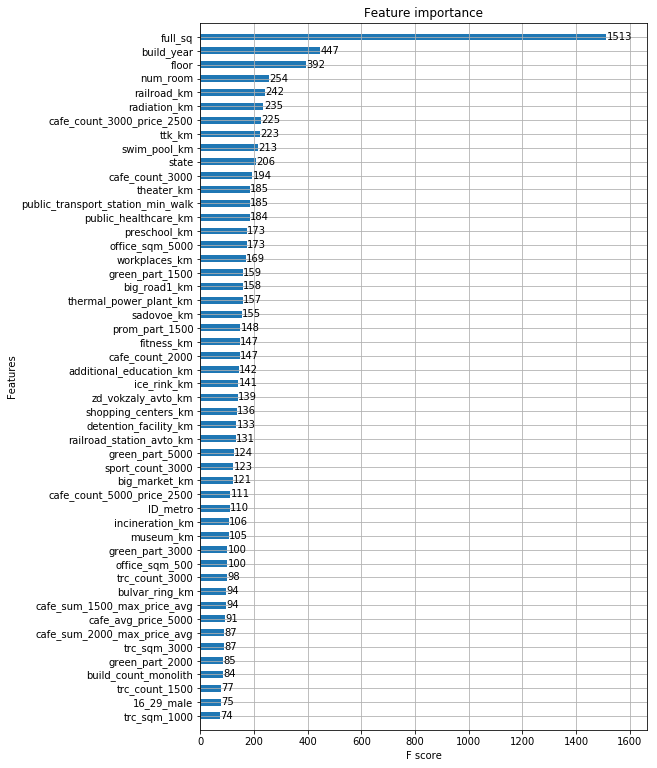

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [78]:
y_predict = model.predict(dtest)

In [79]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5598162.5
1,30475,8275638.5
2,30476,5461720.0
3,30477,6043752.5
4,30478,5435767.5


In [80]:
output.to_csv('submission_dataOK.csv',index = False)